In [3]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
#import scipy.stats as stats

In [4]:


#parse data
def xml_to_datasets(data_file):
    tree = ET.parse(data_file)
    root = tree.getroot()
    datasets = []
    for dataset in root:
        currents = []
        current_std = []
        voltages = []
        voltage_std = []
        for entry in dataset:
            if entry.tag == 'Current':
                currents.append(float(entry[0].text))
                current_std.append(float(entry[1].text))
            elif entry.tag == 'Voltage':
                voltages.append(float(entry[0].text))
                voltage_std.append(float(entry[1].text))
        item = [[currents, current_std], [voltages, voltage_std]]
        datasets.append(item)
    return datasets

In [ ]:
#plot data functions
def plot_iv(datasets, colour, label):
    
    i = 0
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        if i % 10 == 0:
            ax[0].errorbar(voltages,currents,xerr = voltage_std, yerr = current_std, label = label, color = colour ) #str("t="+str(i)) for label, colour is(i/len(datasets), 0, 1 - i/len(datasets)) for overtime ivs
        else:
            pass
            #ax[0].errorbar(voltages,currents,xerr = voltage_std, yerr = current_std, color = (i/len(datasets), 0, 1 - i/len(datasets)))
        i+=1
    

#linear fit at steepest point to find threshold voltage
def plot_steepest_line(datasets, colour, label):
    
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        max_derivative = 0
        max_derivative_index = 0
        for i in range(len(currents) - 1):
            if voltages[i + 1] - voltages[i] > 0.01:
                gradient = (currents[i + 1] - currents[i]) / (voltages[i + 1] - voltages[i])
                if gradient > max_derivative and currents[i] > 0:
                    max_derivative = gradient
                    max_derivative_index = i
                    gradient_err = gradient * np.sqrt((current_std[i] / currents[i])**2 + (current_std[i+1] / currents[i+1])**2 + (voltage_std[i + 1] / voltages[i + 1])**2 + (voltage_std[i] / voltages[i])**2)
        f = lambda x : max_derivative * (x - voltages[max_derivative_index]) + currents[max_derivative_index]
        ax[0].errorbar(voltages, list(map(f,(voltages))),fmt="--", color = colour, label= label)

        #error calculations
        x_intercept = (-currents[max_derivative_index] / max_derivative) + voltages[max_derivative_index]
        error = np.sqrt(((currents[max_derivative_index] / max_derivative) * np.sqrt((current_std[max_derivative_index] / currents[max_derivative_index])**2 + (gradient_err / max_derivative)**2))**2 + voltage_std[max_derivative_index]**2)
        print("Steepest Line Threshold voltage: ", x_intercept, "+/-", error)
    return x_intercept, error

def calculate_derivative(x, y):
    derivative = np.array([])
    for i in range(1, len(y) - 1):
        if x[i + 1] - x[i - 1] > 0.02:
            gradient = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1])
            derivative = np.append(derivative, gradient)
    return list(derivative)

def calculate_smoothed_derivative(x, y):
    derivative = np.array([])
    r = 7
    NC = r * (r + 1) * (2 * r + 1) / 3
    for i in range(r, len(y) - r - 1):
        if x[i + 1] - x[i - 1] > 0.02:
            sum = 0
            for j in range(-r, r + 1):
                sum += y[i + j] * j
            derivative = np.append(derivative, (sum / NC) * (1/((x[i+1]-x[i])+(x[i]-x[i-1]))/2))
    return list(derivative)

#calculate and plot derivative
def plot_derivative(datasets):
    for dataset in datasets:
        currents = dataset[0][0]
        voltages = dataset[1][0]
        derivative = calculate_smoothed_derivative(voltages, currents)
        offset = int(-(len(derivative) - len(voltages)) / 2)
        voltages = voltages[offset:-offset]
        derivative2 = calculate_derivative(voltages, derivative)
        max_current = max(currents)
        scaled_derivative2 = np.array(derivative2) * (max_current / max(derivative2))
        offset = int(-(len(derivative2) - len(voltages)) / 2)
        voltages = voltages[offset:-offset]
        if len(voltages) != len(derivative2):
            voltages = voltages[:-1]
        ax[0].errorbar(voltages,scaled_derivative2,fmt="--", color = 'green', label = 'Derivative of $I_d$ w.r.t. V')
        index_max_derivative2 = derivative2.index(max(derivative2))
        max_derivative2_voltage = voltages[index_max_derivative2]
        error = max((voltages[index_max_derivative2 + 1]) - max_derivative2_voltage, max_derivative2_voltage - voltages[index_max_derivative2 - 1])
        print("Second Derivative Maximum: ", max_derivative2_voltage, "+/-", error)
    return max_derivative2_voltage, error
#calculate and plot derivative calculation of threshold voltages over time
def plot_derivative_thresholds_time(datasets, times=None, colour = "green", label="2nd derivative method"):
    max_derivative2_voltages = []
    errors = []
    if times == None:
        times = range(0, len(datasets))
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        derivative = calculate_smoothed_derivative(voltages, currents)
        offset = int(-(len(derivative) - len(voltages)) / 2)
        voltages = voltages[offset:-offset]
        derivative2 = calculate_derivative(voltages, derivative)
        offset = int(-(len(derivative2) - len(voltages)) / 2)
        voltages = voltages[offset:-offset-1]
        index_max_derivative2 = derivative2.index(max(derivative2))
        max_derivative2_voltages.append(voltages[index_max_derivative2])
        errors.append(max((voltages[index_max_derivative2 + 1]) - voltages[index_max_derivative2], voltages[index_max_derivative2] - voltages[index_max_derivative2 - 1]))
    ax[0].errorbar(times, max_derivative2_voltages, yerr = errors, color = colour, label = label)

def plot_steepest_threshold_time(datasets, times=None, colour = "red", label="Steepest line method"):
    x_intercepts = []
    errors = []
    if times == None:
        times = range(0, len(datasets))
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        max_derivative = 0
        max_derivative_index = 0
        for i in range(len(currents) - 1):
            if voltages[i + 1] - voltages[i] > 0.01:
                gradient = (currents[i + 1] - currents[i]) / (voltages[i + 1] - voltages[i])
                if gradient > max_derivative and currents[i] > 0:
                    max_derivative = gradient
                    max_derivative_index = i
                    gradient_err = gradient * np.sqrt((current_std[i] / currents[i])**2 + (current_std[i+1] / currents[i+1])**2 + (voltage_std[i + 1] / voltages[i + 1])**2 + (voltage_std[i] / voltages[i])**2)
        f = lambda x : max_derivative * (x - voltages[max_derivative_index]) + currents[max_derivative_index]
        #error calculations
        x_intercept = (-currents[max_derivative_index] / max_derivative) + voltages[max_derivative_index]
        error = np.sqrt(0.005**3 + ((currents[max_derivative_index] / max_derivative) * np.sqrt((current_std[max_derivative_index] / currents[max_derivative_index])**2 + (gradient_err / max_derivative)**2))**2 + voltage_std[max_derivative_index]**2)
        x_intercepts.append(x_intercept)
        errors.append(error)
    ax[0].errorbar(times, x_intercepts, yerr = errors, color = colour, label=label)
    return [x_intercepts, errors]

In [6]:
#parse xml file
data_file = 'xml_Data/Ba133_uniradiated_linear.xml'#
data_file2 ='xml_Data/ba133_iradiated_linear.xml'

datasets = xml_to_datasets(data_file)
if data_file2 != None:
    datasets2 = xml_to_datasets(data_file2)

In [7]:
def steepest_time_best_fit(datasets, colour = 'red', label = 'Best fit line'):
    Threshs, thresherrs= plot_steepest_threshold_time(datasets, colour=colour, label = label)
    times , timeerr = range(0, len(datasets)), (3600000)**-1 #1ms
    params = np.polyfit(times, Threshs, 1) #gradient [0] and intercept [1]
    
        
    param0err = params[0]*np.sqrt((thresherrs[0]/Threshs[0])**2+ (thresherrs[-1]/Threshs[-1])**2)
    param1err = thresherrs[-1]
    line = params[1] + params[0]*times
    ax[0].plot(times, line, color = 'blue')
    diff = np.abs(line[0]-line[-1])
    differr = np.sqrt(thresherrs[0]**2 + thresherrs[-1]**2)
    print('Difference in Voltage =' + str(diff) + ' +/- ' + str(differr) + ' V' )
    return [Threshs, thresherrs]

def plot_iv_mA(datasets):
    
    i = 0
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        if i % 10 == 0:
            ax[0].errorbar(voltages,1000*currents,xerr = voltage_std, yerr = 1000*current_std, label = str("t="+str(i)), color = (i/len(datasets), 0, 1 - i/len(datasets)))
        else:
            pass
            #ax[0].errorbar(voltages,currents,xerr = voltage_std, yerr = current_std, color = (i/len(datasets), 0, 1 - i/len(datasets)))
        i+=1
def plot_steepest_line_mA(datasets):
    
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        max_derivative = 0
        max_derivative_index = 0
        for i in range(len(currents) - 1):
            if voltages[i + 1] - voltages[i] > 0.01:
                gradient = (currents[i + 1] - currents[i]) / (voltages[i + 1] - voltages[i])
                if gradient > max_derivative and currents[i] > 0:
                    max_derivative = gradient
                    max_derivative_index = i
                    gradient_err = gradient * np.sqrt((current_std[i] / currents[i])**2 + (voltage_std[i + 1] / voltages[i + 1])**2 + (voltage_std[i] / voltages[i])**2)
        f = lambda x : max_derivative * (x - voltages[max_derivative_index]) + currents[max_derivative_index]
        ax[0].errorbar(voltages, 1000*list(map(f,(voltages))),fmt="--", color = 'gray', label="Steepest Line")

        #error calculations
        x_intercept = (-currents[max_derivative_index] / max_derivative) + voltages[max_derivative_index]
        error = np.sqrt((currents[max_derivative_index] / max_derivative) * np.sqrt((current_std[max_derivative_index] / currents[max_derivative_index])**2 + (gradient_err / max_derivative)**2)**2 + voltage_std[max_derivative_index]**2)
        print("Steepest Line Threshold voltage: ", x_intercept, "+/-", error)

Steepest Line Threshold voltage:  1.8402987500000003 +/- 0.0064211212235751125


<function matplotlib.pyplot.show(close=None, block=None)>

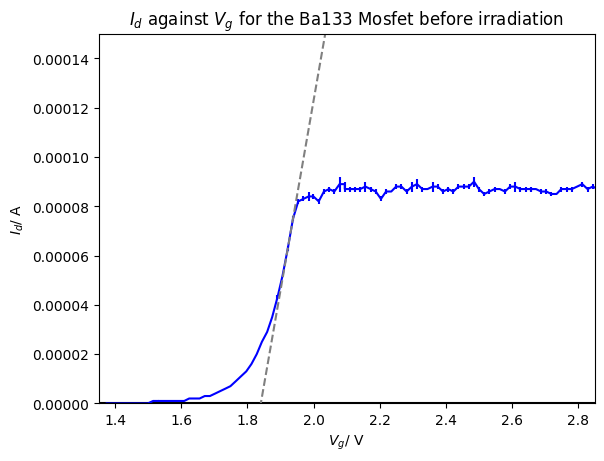

In [8]:
fig, ax = plt.subplots()
ax = [ax]
ax[0].set_xlim(1.35, 2.85)
ax[0].set_ylim(0, 0.00015)
plot_iv(datasets, colour = 'blue', label = 'Before Irradiation')
#plot_derivative(datasets)
plot_steepest_line(datasets, colour = 'gray', label = None)

plt.axhline(y = 0, color = 'black')
plt.title( "$I_d$ against $V_g$ for the Ba133 Mosfet before irradiation")
ax[0].set_ylabel('$I_d$/ A')
ax[0].set_xlabel('$V_g$/ V')
plt.show

Difference in Voltage =0.024914220299509404 +/- 0.002486779293680181 V


Text(0.5, 0, 'Elapsed Time/ Hours')

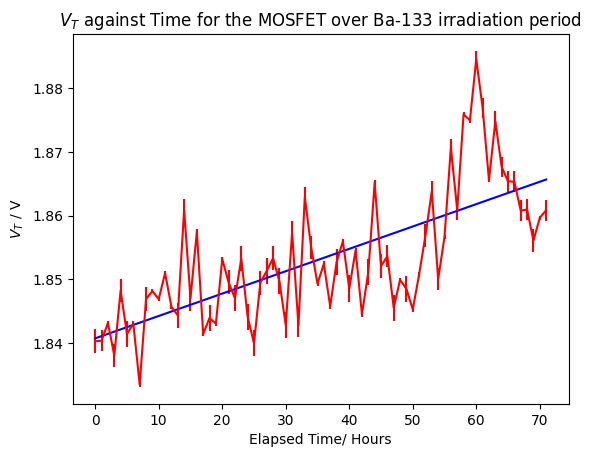

In [12]:
fig, ax = plt.subplots()
ax = [ax]

thing11, thing21 = steepest_time_best_fit(datasets2)
#thing12, thing22 = plot_derivative_thresholds_time(datasets2)
#print('Difference in Threshold Voltage via steepest line method = ' + str(np.abs(thing11[0]-thing11[-1])) + ' +/- ' + str(np.sqrt(thing21[0]**2+thing21[-1]**2)))
#print('Difference in Threshold Voltage via 2nd derivative method= ' + str(np.abs(thing12[0]-thing12[-1])) + ' +/- ' + str(np.sqrt(thing22[0]**2+thing22[-1]**2)))
plt.title( "$V_T$ against Time for the MOSFET over Ba-133 irradiation period")
ax[0].set_ylabel('$V_T$ / V')
ax[0].set_xlabel('Elapsed Time/ Hours')

#plt.legend(loc = 'upper left')

In [52]:
#Archeology 6 Gray
data_file3 = 'xml_Data/arch5unirradiated.xml'
data_file4 = 'xml_Data/arch5irradiated_2.xml'
datasets3 = xml_to_datasets(data_file3)
datasets4 = xml_to_datasets(data_file4)
len(thing11)

72

Second Derivative Maximum:  2.015064 +/- 0.01601700000000017
Second Derivative Maximum:  2.014874 +/- 0.016025999999999874
Steepest Line Threshold voltage:  1.9512102291666658 +/- 0.005631235044027014
Steepest Line Threshold voltage:  2.020675518518518 +/- 0.010349138728401394


<function matplotlib.pyplot.show(close=None, block=None)>

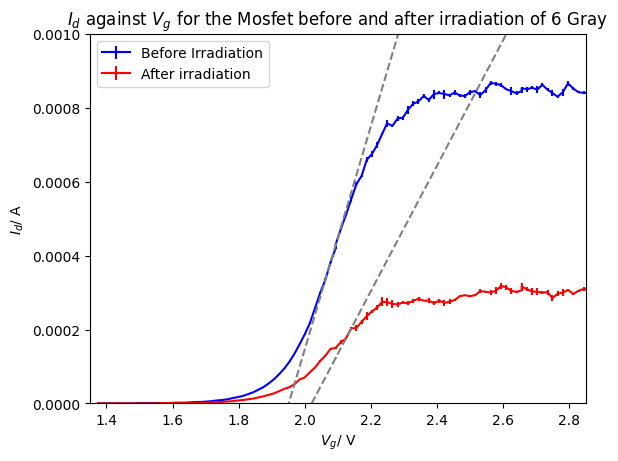

In [11]:
plot_derivative(datasets3)
plot_derivative(datasets4)
fig, ax = plt.subplots()
ax = [ax]
plot_iv(datasets3, colour = 'blue', label = 'Before Irradiation')
plot_iv(datasets4, colour = 'red', label = 'After irradiation')
ax[0].set_xlim(1.35, 2.85)
ax[0].set_ylim(0, 0.0010)

plot_steepest_line(datasets3, colour = 'gray', label = None)
plot_steepest_line(datasets4, colour = 'gray', label = None)


#plt.axhline(y = 0, color = 'black')
plt.title( "$I_d$ against $V_g$ for the Mosfet before and after irradiation of 6 Gray")
ax[0].set_ylabel('$I_d$/ A')
ax[0].set_xlabel('$V_g$/ V')
plt.legend()
plt.show

In [12]:
#Archeology 3 Gray
data_file5 = 'xml_Data/arch25unirradiated.xml'
data_file6 = 'xml_Data/arch25irradiated.xml'
datasets5 = xml_to_datasets(data_file5)
datasets6 = xml_to_datasets(data_file6)

Second Derivative Maximum:  2.015064 +/- 0.01601700000000017
Second Derivative Maximum:  2.014874 +/- 0.016025999999999874
Steepest Line Threshold voltage:  1.9631503018867924 +/- 0.006307517005473861
Steepest Line Threshold voltage:  1.963317791666669 +/- 0.0076998501953101815


<function matplotlib.pyplot.show(close=None, block=None)>

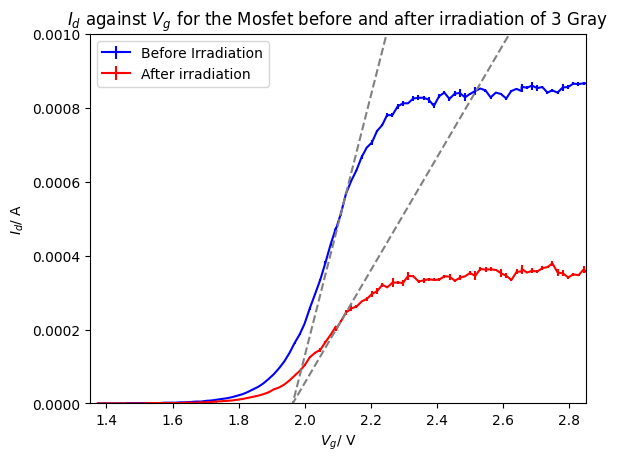

In [13]:
plot_derivative(datasets3)
plot_derivative(datasets4)
fig, ax = plt.subplots()
ax = [ax]
plot_iv(datasets5, colour = 'blue', label = 'Before Irradiation')
plot_iv(datasets6, colour = 'red', label = 'After irradiation')
ax[0].set_xlim(1.35, 2.85)
ax[0].set_ylim(0, 0.0010)

plot_steepest_line(datasets5, colour = 'gray', label = None)
plot_steepest_line(datasets6, colour = 'gray', label = None)


#plt.axhline(y = 0, color = 'black')
plt.title( "$I_d$ against $V_g$ for the Mosfet before and after irradiation of 3 Gray")
ax[0].set_ylabel('$I_d$/ A')
ax[0].set_xlabel('$V_g$/ V')
plt.legend()
plt.show

Steepest Line Threshold voltage:  1.9512102291666658 +/- 0.005631235044027014
Steepest Line Threshold voltage:  2.020675518518518 +/- 0.010349138728401394
Steepest Line Threshold voltage:  1.9512102291666658 +/- 0.005631235044027014
Steepest Line Threshold voltage:  2.020675518518518 +/- 0.010349138728401394
Steepest Line Threshold voltage:  1.9631503018867924 +/- 0.006307517005473861
Steepest Line Threshold voltage:  1.963317791666669 +/- 0.0076998501953101815
Steepest Line Threshold voltage:  1.9631503018867924 +/- 0.006307517005473861
Steepest Line Threshold voltage:  1.963317791666669 +/- 0.0076998501953101815


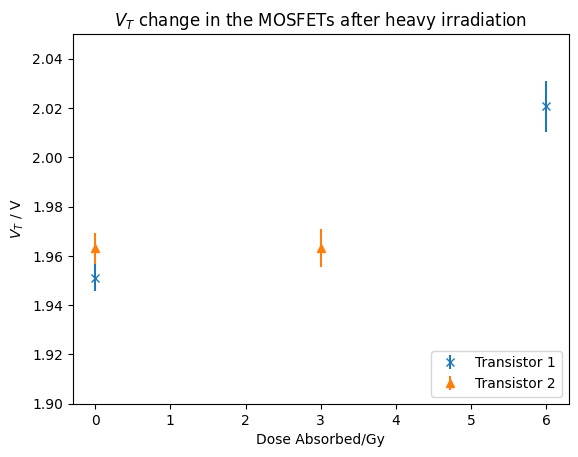

In [14]:

VT5, Errs6 = [plot_steepest_line(datasets3, colour = 'blue', label = None)[0],plot_steepest_line(datasets4, colour = 'blue', label = None)[0] ], [
[plot_steepest_line(datasets3, colour = 'blue', label = None)[1], plot_steepest_line(datasets4, colour = 'blue', label = None)[1]]
]

Grays5 = [0,6]

VT25, Errs3 = [ plot_steepest_line(datasets5, colour = 'red', label = None)[0], 
                plot_steepest_line(datasets6, colour = 'red', label = None)[0]], [ plot_steepest_line(datasets5, colour = 'red', label = None)[1], 
plot_steepest_line(datasets6, colour = 'red', label = None)[1]]

Grays25 = [0,3]

fig, ax = plt.subplots()
ax = [ax]
ax[0].errorbar(Grays5, VT5,yerr = Errs6, label = 'Transistor 1', fmt= 'x')
ax[0].errorbar(Grays25, VT25,yerr = Errs3, label = 'Transistor 2', fmt= '^')
#plot_derivative_thresholds_time(datasets2)
plt.title( "$V_T$ change in the MOSFETs after heavy irradiation")
ax[0].set_ylabel('$V_T$ / V')
ax[0].set_xlabel('Dose Absorbed/Gy')
ax[0].set_ylim(1.9, 2.05)
plt.legend(loc = 'lower right')

<function matplotlib.pyplot.show(close=None, block=None)>

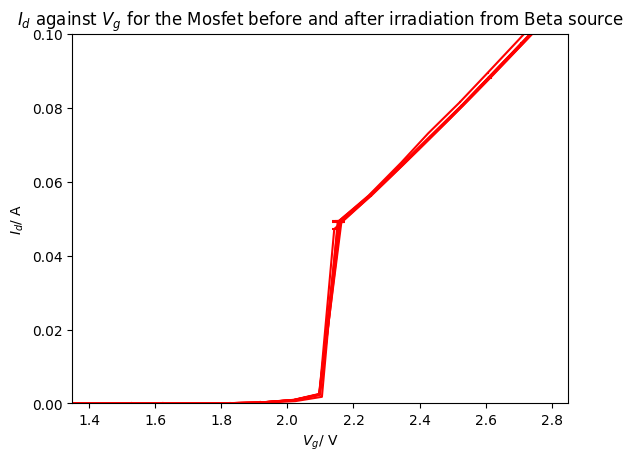

In [23]:
#Cs-137 
beta92_file1 = 'xml_Data/uniradiated_mosfet_beta92.xml'
beta92_file2 = 'xml_Data/mosfet_beta92_overnight.xml'
beta92_file3 = 'xml_Data/mosfet_overweekend_beta.xml'
beta92_file4 = 'xml_Data/Data_Overweekend_Beta.xml' # resistor
beta92_file5 = 'xml_Data/mosfet_beta2.xml'

datasetsbeta1 = xml_to_datasets(beta92_file1)
datasetsbeta2 = xml_to_datasets(beta92_file2)
datasetsbeta3 = xml_to_datasets(beta92_file3)
datasetsbeta4 = xml_to_datasets(beta92_file4)
datasetsbeta5 = xml_to_datasets(beta92_file5)

#plot_derivative(datasetsbeta1)
#plot_derivative(datasetsbeta2)
#plot_derivative(datasetsbeta3)
#plot_derivative(datasetsbeta4)
fig, ax = plt.subplots()
ax = [ax]
#plot_iv(datasetsbeta1, colour = 'blue', label = 'Before Irradiation')
#plot_iv(datasetsbeta2, colour = 'green', label = 'After overnight irradiation')
plot_iv(datasetsbeta3, colour = 'red', label = 'After overweekend irradiation')

ax[0].set_xlim(1.35, 2.85)
ax[0].set_ylim(0, 0.10)


#plt.axhline(y = 0, color = 'black')
plt.title( "$I_d$ against $V_g$ for the Mosfet before and after irradiation from Beta source")
ax[0].set_ylabel('$I_d$/ A')
ax[0].set_xlabel('$V_g$/ V')
#plt.legend()

plt.show

Difference in Voltage =0.11742791004056499 +/- 0.06764320785836046 V
Difference in Voltage =0.2453163381922634 +/- 0.11115340015354364 V
Difference in Resistance = 0.04098146479768472  +/- 0.06764320785836046 Ohms
Difference in Resistance = 0.16041537167665545 +/- 0.11115340015354364 Ohms


21

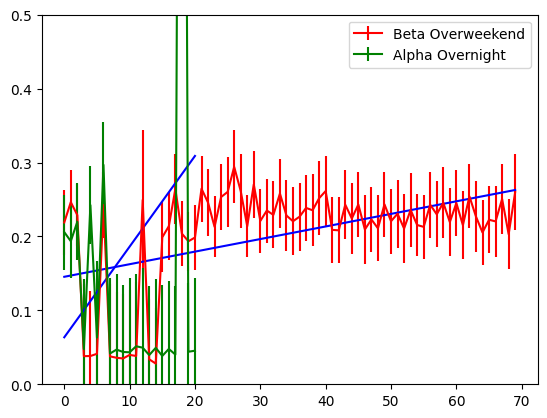

In [54]:
#Change in resistance
alphafile = 'xml_Data/Data_Overnight_Alpha.xml'
alphadata = xml_to_datasets(alphafile)
fig, ax = plt.subplots()
ax = [ax]
ax[0].set_ylim(0, 0.50)
thing1, thing2 =steepest_time_best_fit(datasetsbeta4, colour = 'red', label = 'Beta Overweekend')
thing3, thing4 =steepest_time_best_fit(alphadata, colour = 'green', label = 'Alpha Overnight')
plt.legend()
Diffbeta, errbeta = np.abs(thing1[0]-thing1[-1]), np.sqrt(thing2[0]**2+thing2[-1]**2)
Diffalpha, erralpha = np.abs(thing3[0]-thing3[-1]), np.sqrt(thing4[0]**2+thing4[-1]**2)
print('Difference in Resistance = ' + str(Diffbeta) + '  +/- ' + str(errbeta) + ' Ohms') 
print('Difference in Resistance = ' + str(Diffalpha) + ' +/- ' + str(erralpha) + ' Ohms')
len(thing3)

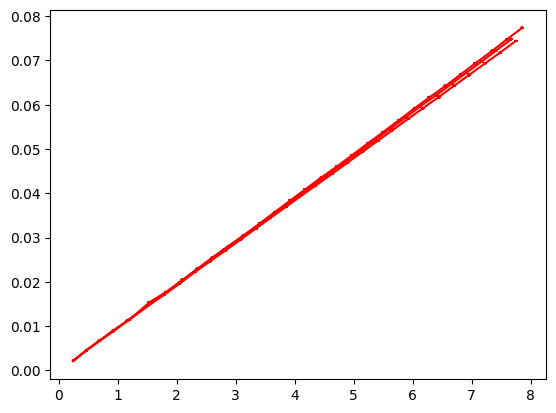

In [ ]:
fig, ax = plt.subplots()
ax = [ax]
plot_iv(alphadata, colour = 'red', label = None)

Difference in Voltage =0.004687233596160301 +/- 0.007556016546759218 V


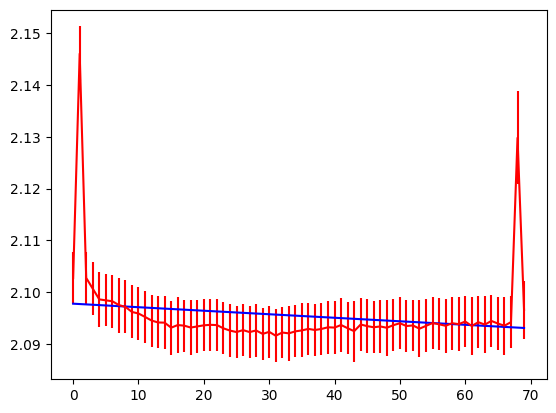

In [55]:
#Cs-137 mosftet over time
fig, ax = plt.subplots()
ax = [ax]
#plot_steepest_threshold_time(datasetsbeta1, colour = 'red', label = None) # this is just 1 point
#plot_steepest_threshold_time(datasetsbeta2, colour = 'orange', label = None)
alan, glep = steepest_time_best_fit(datasetsbeta3, colour = 'red', label = None)
#plot_steepest_threshold_time(datasetsbeta4, colour = 'green', label = None)
DiffbetaT, errbetaT = np.abs(alan[0]-alan[-1]), np.sqrt(glep[0]**2+glep[-1]**2)

#print('Difference in Voltage = ' + str(DiffbetaT) + ' V +/- ' + str(errbetaT)) 


70